<a href="https://colab.research.google.com/github/tofaratifolayan/potato_virus_classification/blob/main/PotatoKaggleClassifierWithAddedHealthyPotatoData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtain the data

In [ ]:
#!/bin/bash
!curl -L -o potato-viral-disease-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/nirmalsankalana/potato-viral-disease-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  799M  100  799M    0     0  21.0M      0  0:00:37  0:00:37 --:--:-- 23.4M


# Prepare image paths and labels

In [ ]:
import os
import pandas as pd

file_paths = []
labels = []
class_dict = {"Potato___healthy": 0, "Potato___leafroll_virus": 1, "Potato___mosaic_virus": 2, "Potato___spindle_tuber_viroid": 3, "Potato__healthy_bulb": 4}
class_folders = os.listdir("/content/potato-viral-disease-dataset")
# Iterate over each class folder
for label, class_name in enumerate(class_folders):
    class_folder = os.path.join("/content/potato-viral-disease-dataset", class_name)

    # Check if it's a directory
    if os.path.isdir(class_folder):
        for file_name in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file_name)
            if not os.path.isdir(file_path):
              file_paths.append(file_path)
              # Store class name as label
              labels.append(class_dict[class_name])

# Create a DataFrame
df = pd.DataFrame({"file_path": file_paths, "label": labels})

# Display the first few rows
# pd.set_option('display.max_colwidth', None)
print(df)


                                              file_path  label
0     /content/potato-viral-disease-dataset/Potato__...      3
1     /content/potato-viral-disease-dataset/Potato__...      3
2     /content/potato-viral-disease-dataset/Potato__...      3
3     /content/potato-viral-disease-dataset/Potato__...      3
4     /content/potato-viral-disease-dataset/Potato__...      3
...                                                 ...    ...
1558  /content/potato-viral-disease-dataset/Potato__...      2
1559  /content/potato-viral-disease-dataset/Potato__...      2
1560  /content/potato-viral-disease-dataset/Potato__...      2
1561  /content/potato-viral-disease-dataset/Potato__...      2
1562  /content/potato-viral-disease-dataset/Potato__...      2

[1563 rows x 2 columns]


# Custom Dataset class




In [ ]:
from torch.utils.data import Dataset, DataLoader

from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image, return_tensors="pt")

        return image, label

# Set up ViT model from Hugging Face

In [ ]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Overwrite Vit Config
model.config.id2label = {"0": "Potato___healthy", "1": "Potato___leafroll_virus", "2": "Potato___mosaic_virus", "3": "Potato___spindle_tuber_viroid", "4": "Potato__healthy_bulb"}
model.config.label2id = {"Potato___healthy": "0", "Potato___leafroll_virus": "1", "Potato___mosaic_virus": "2", "Potato___spindle_tuber_viroid": "3", "Potato__healthy_bulb": "4"}
model.classifier = torch.nn.Linear(in_features=768, out_features=5, bias=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Split Train and Test Data


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_dataset = ImageDataset(train_df, transform=image_processor)
test_dataset = ImageDataset(test_df, transform=image_processor)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=2
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=2
)

# Finetuning Parameter Setup


In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define learning rates

# Lower LR for pretrained ViT layers
backbone_lr = 2e-5
# Higher LR for classification head
classifier_lr = 1e-3  # Higher LR for classification head

# Separate model parameters
# Classification head
classifier_params = list(model.classifier.parameters())
# Everything else
backbone_params = [p for n, p in model.named_parameters() if "classifier" not in n]

# Define optimizer with different LR groups
optimizer = AdamW([
    {"params": backbone_params, "lr": backbone_lr},
    {"params": classifier_params, "lr": classifier_lr}
], weight_decay=0.01)


# Pretraining Results

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        pixel_values = batch[0]['pixel_values'].to(device)
        pixel_values= pixel_values.squeeze(1)
        labels = batch[1].to(device)

        outputs = model(pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.0767


# Finetune Model

In [ ]:
from tqdm import tqdm
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader):
        pixel_values = batch[0]['pixel_values'].to(device)
        pixel_values= pixel_values.squeeze(1)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values)
        loss = F.cross_entropy(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Validation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_dataloader:
            pixel_values = batch[0]['pixel_values'].to(device)
            pixel_values= pixel_values.squeeze(1)
            labels = batch[1].to(device)

            outputs = model(pixel_values)
            preds = torch.argmax(outputs.logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")


100%|██████████| 10/10 [01:09<00:00,  6.91s/it]

Epoch 1/5, Loss: 0.7649


Validation Accuracy: 0.9744


100%|██████████| 10/10 [01:11<00:00,  7.16s/it]

Epoch 2/5, Loss: 0.0919


Validation Accuracy: 0.9904


100%|██████████| 10/10 [01:20<00:00,  8.01s/it]

Epoch 3/5, Loss: 0.0187


Validation Accuracy: 0.9936


100%|██████████| 10/10 [01:09<00:00,  6.95s/it]

Epoch 4/5, Loss: 0.0052


Validation Accuracy: 0.9936


100%|██████████| 10/10 [01:10<00:00,  7.03s/it]

Epoch 5/5, Loss: 0.0027


Validation Accuracy: 0.9936


# Save Model

In [ ]:

# Save model parameters
torch.save(model.state_dict(), "potatoLeafVit-1.pth")


Text(0.5, 1.0, 'Confusion Matrix')

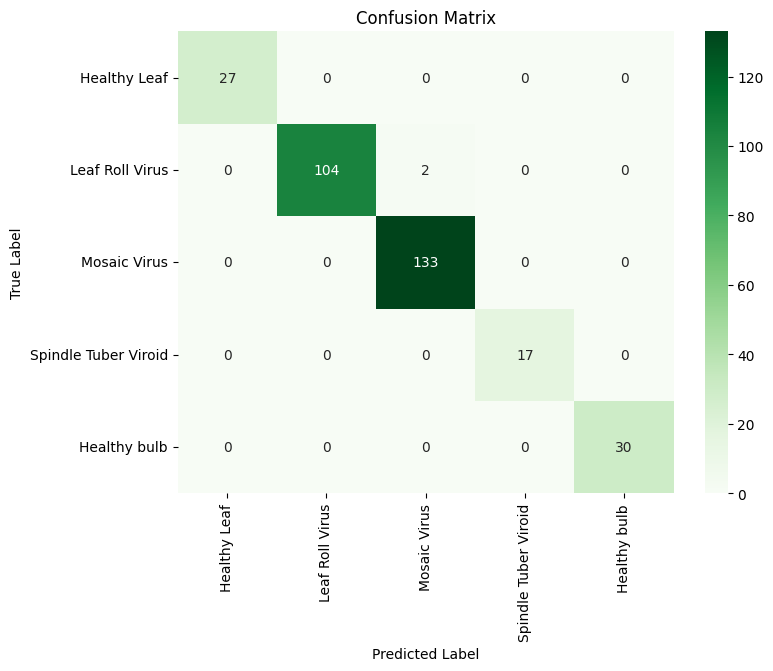

In [ ]:
# Define class names

model.to(device)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        pixel_values = batch[0]['pixel_values'].to(device)
        pixel_values = pixel_values.squeeze(1)
        labels = batch[1].to(device)

        outputs = model(pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())  # Move to CPU for sklearn
        all_labels.extend(labels.cpu().numpy())


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


class_names = ["Healthy Leaf", "Leaf Roll Virus", "Mosaic Virus", "Spindle Tuber Viroid", "Healthy bulb"]

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot

# Load Model

In [ ]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch


image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

model.config.id2label = {"0": "Potato___healthy", "1": "Potato___leafroll_virus", "2": "Potato___mosaic_virus", "3": "Potato___spindle_tuber_viroid", "4": "Potato__healthy_bulb"}
model.config.label2id = {"Potato___healthy": "0", "Potato___leafroll_virus": "1", "Potato___mosaic_virus": "2", "Potato___spindle_tuber_viroid": "3", "Potato__healthy_bulb": "4"}
model.classifier = torch.nn.Linear(in_features=768, out_features=5, bias=True)

model.load_state_dict(torch.load("potatoLeafVit-1.pth", weights_only=True))


<All keys matched successfully>

# Predict Test Samples

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

model.to(device)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        pixel_values = batch[0]['pixel_values'].to(device)
        pixel_values = pixel_values.squeeze(1)
        labels = batch[1].to(device)

        outputs = model(pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute F1-Score

In [ ]:
# Compute F1-score
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Validation F1-score: {f1:.4f}")

Validation F1-score: 0.9936


# Graph Misclassified

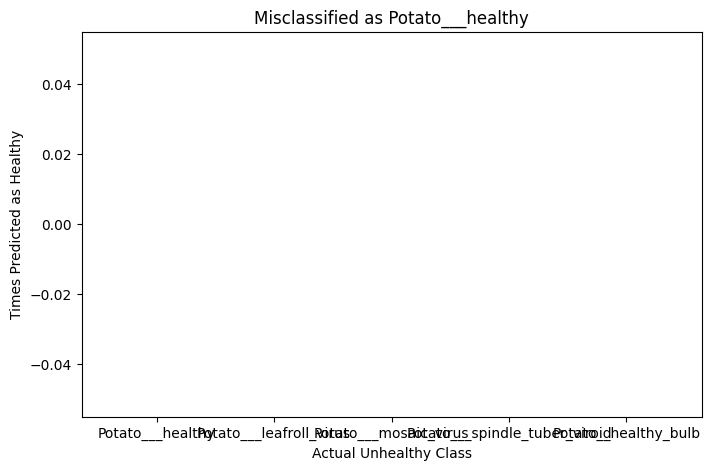

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Find misclassified "Potato___healthy"
false_sick = (all_preds != 0) & (all_labels == 0)
# Count misclassifications per true class
misclassified_counts = {model.config.id2label[str(i)]: np.sum(all_labels[false_sick] == i) for i in range(0, 5)}

# Plot results
plt.figure(figsize=(8, 5))
plt.bar(misclassified_counts.keys(), misclassified_counts.values(), color='red')
plt.xlabel("Actual Unhealthy Class")
plt.ylabel("Times Predicted as Healthy")
plt.title("Misclassified as Potato___healthy")
plt.show()

# Combine Test and Training Data

In [ ]:

all_dataset = ImageDataset(df, transform=image_processor)

all_dataloader = DataLoader(
    all_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=2
)

model.to(device)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in all_dataloader:
        pixel_values = batch[0]['pixel_values'].to(device)
        pixel_values = pixel_values.squeeze(1)
        labels = batch[1].to(device)

        outputs = model(pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())  # Move to CPU for sklearn
        all_labels.extend(labels.cpu().numpy())


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


# Compute F1-Score for All Data


In [ ]:
# Compute F1-score
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Validation F1-score: {f1:.4f}")

Validation F1-score: 0.9987


# Confusion Matrix

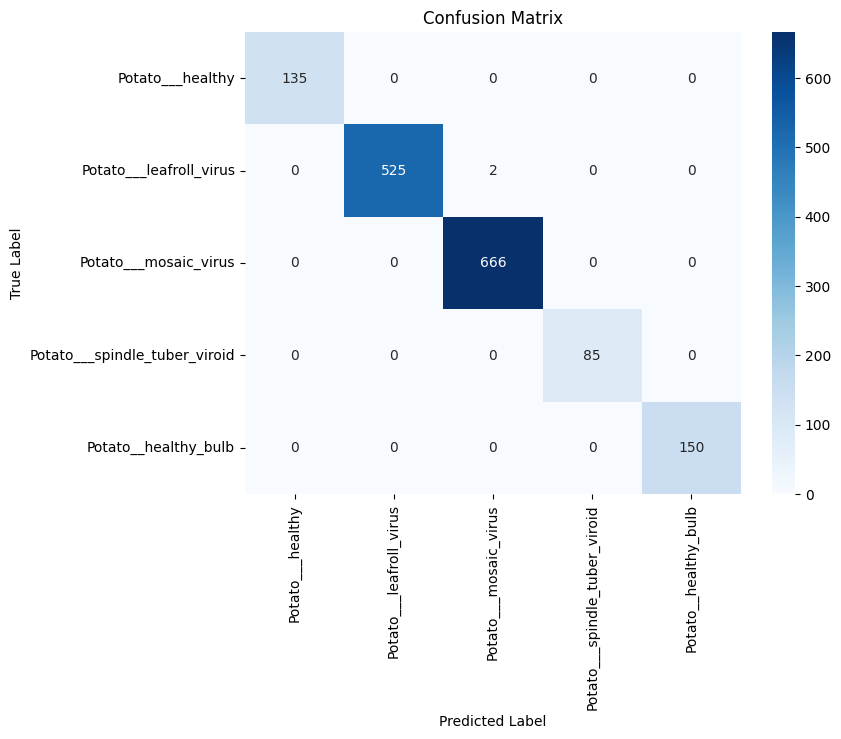

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Define class names
class_names = ["Potato___healthy", "Potato___leafroll_virus", "Potato___mosaic_virus", "Potato___spindle_tuber_viroid", "Potato__healthy_bulb"]

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Show Mis-classified Images

In [ ]:
misclassified_indices = np.where(all_labels != all_preds)[0]

# Print indices and corresponding true/predicted labels
print("Misclassified Indices & Labels:")
for idx in misclassified_indices:
    print(f"Index: {idx}, True Label: {all_labels[idx]}, Predicted: {all_preds[idx]}")

Misclassified Indices & Labels:
Index: 422, True Label: 1, Predicted: 2
Index: 567, True Label: 1, Predicted: 2


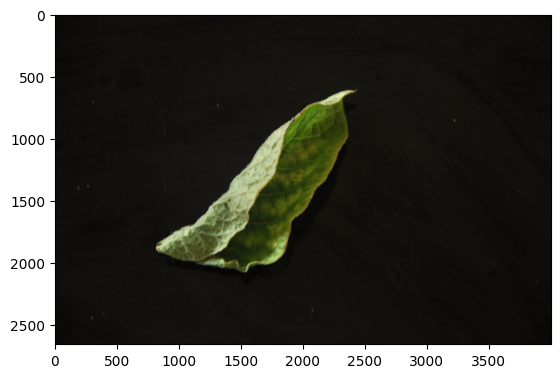

In [ ]:
all_unprocessed = ImageDataset(df, transform=None)


plt.imshow(all_unprocessed[462][0])
